[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_4_cnn.ipynb)

# 4. Convolutional Neural Networks

In [0]:
%tensorflow_version 1.x
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


In [0]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [0]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
gray = False
if len(raw_x_train.shape)==4 and gray:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
cdim = raw_x_train.shape[3]
print(raw_x_train.dtype, raw_y_train.dtype)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1)
uint8 uint8


[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


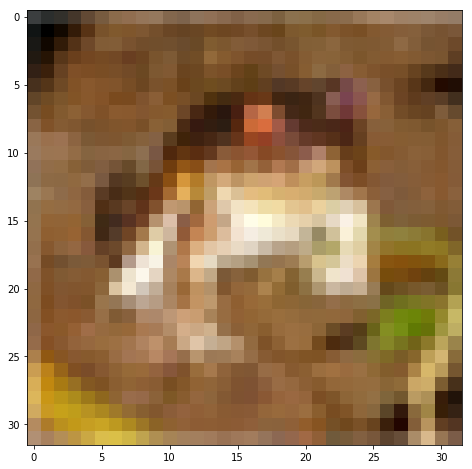

In [0]:
print(raw_x_train[0])
print(raw_y_train[0])
if gray:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [0]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0 255 117.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [0]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train/255
x_test = raw_x_test/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)

In [0]:
def get_model(bn):
    inputs = Input(shape=(xdim, ydim, cdim))
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Flatten()(f)
    f = Dense(512, activation='relu')(f)
    f = Dropout(0.5)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

In [0]:
model = get_model(bn=False)
print(model.summary())
print((3*3*3+1)*32+(3*3*32+1)*32+(3*3*32+1)*64+(3*3*64+1)*64+((((32-2-2)/2-2-2)/2)**2*64+1)*512+(512+1)*10)
print('https://fomoro.com/tools/receptive-fields/#3,1,1,VALID;3,1,1,VALID;2,2,1,VALID;3,1,1,VALID;3,1,1,VALID;2,2,1,VALID')
print(3+2+1+2*(2+2+1))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=150, validation_split=0.2)

W0817 23:18:20.493319 140091292841856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 23:18:20.496883 140091292841856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 23:18:20.508709 140091292841856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 23:18:20.601451 140091292841856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 23:18:20.605246 140091292841856 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
__________

W0817 23:18:21.083201 140091292841856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/150
40000/40000 [==============================] - 17s 414us/step - loss: 2.2399 - acc: 0.1486 - val_loss: 2.0453 - val_acc: 0.2469
Epoch 2/150
40000/40000 [==============================] - 10s 244us/step - loss: 2.0224 - acc: 0.2508 - val_loss: 1.8848 - val_acc: 0.3384
Epoch 3/150
40000/40000 [==============================] - 10s 250us/step - loss: 1.8499 - acc: 0.3240 - val_loss: 1.7230 - val_acc: 0.3689
Epoch 4/150
40000/40000 [==============================] - 10s 247us/step - loss: 1.7436 - acc: 0.3595 - val_loss: 1.6493 - val_acc: 0.3974
Epoch 5/150
40000/40000 [==============================] - 10s 245us/step - loss: 1.6829 - acc: 0.3852 - val_loss: 1.6040 - val_acc: 0.4172
Epoch 6/150
40000/40000 [==============================] - 10s 243us/step - loss: 1.6296 - acc: 0.4018 - val_loss: 1.5412 - val_acc: 0.4350
Epoch 7/150
40000/40000 [==============================] - 10s 246us/step - loss: 1.5826 - acc: 0.4201 - val_l

In [0]:
model = get_model(bn=True)
print(model.summary())
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=150, validation_split=0.2)

W0817 23:42:40.333405 140091292841856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
__________

In [0]:
model = get_model(bn=True)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

valid_idx = int(train_size*0.8)
aug_train_data = datagen.flow(x=x_train[:valid_idx], y=y_train[:valid_idx], batch_size=64, seed=45)
valid_data = (x_train[valid_idx:], y_train[valid_idx:])
history = model.fit_generator(aug_train_data, epochs=150, steps_per_epoch=valid_idx // 64, validation_data=valid_data)

W0818 09:49:28.200656 140455619516288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 09:49:28.209534 140455619516288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 09:49:28.219108 140455619516288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 09:49:28.265694 140455619516288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 09:49:28.267068 1404556195

Epoch 1/150
625/625 [==============================] - 32s 51ms/step - loss: 2.0385 - acc: 0.3095 - val_loss: 1.5426 - val_acc: 0.4376
Epoch 2/150
625/625 [==============================] - 28s 44ms/step - loss: 1.6076 - acc: 0.4128 - val_loss: 1.3969 - val_acc: 0.4977
Epoch 3/150
625/625 [==============================] - 27s 43ms/step - loss: 1.4897 - acc: 0.4562 - val_loss: 1.4257 - val_acc: 0.4931
Epoch 4/150
625/625 [==============================] - 27s 43ms/step - loss: 1.4188 - acc: 0.4859 - val_loss: 1.3595 - val_acc: 0.5151
Epoch 5/150
625/625 [==============================] - 27s 43ms/step - loss: 1.3435 - acc: 0.5143 - val_loss: 1.2579 - val_acc: 0.5511
Epoch 6/150
625/625 [==============================] - 27s 43ms/step - loss: 1.2925 - acc: 0.5341 - val_loss: 1.2207 - val_acc: 0.5706
Epoch 7/150
625/625 [==============================] - 27s 43ms/step - loss: 1.2561 - acc: 0.5478 - val_loss: 1.2316 - val_acc: 0.5603
Epoch 8/150
625/625 [==============================] - 

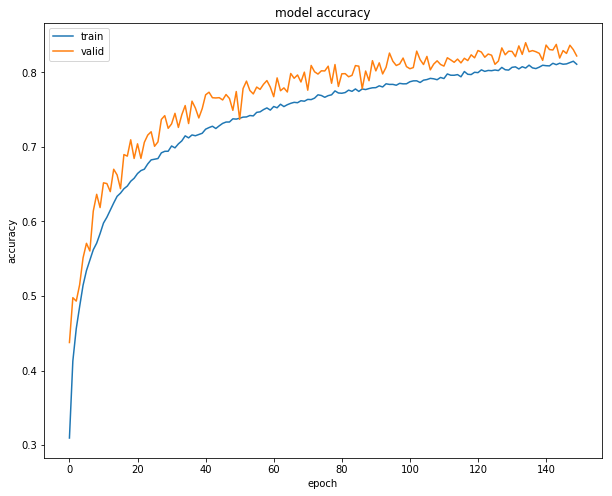

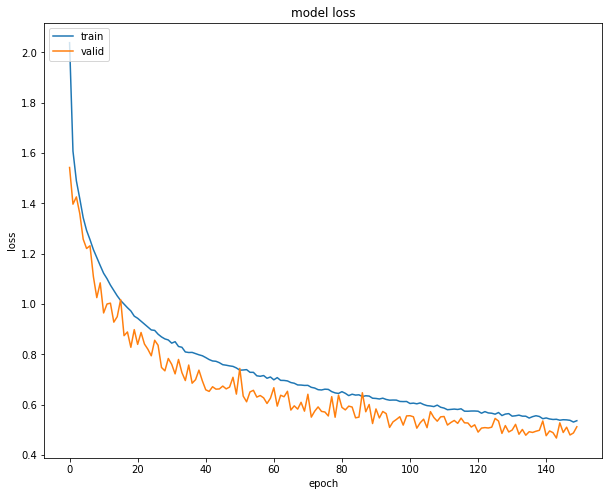

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 2s 202us/step
0.5390828308582306 0.8133
[[851  13  28  10  11   0  16  12  34  25]
 [ 10 912   3   1   2   2  12   0  10  48]
 [ 53   0 669  20  67  33 123  22   4   9]
 [ 12   3  33 575  68  90 170  28   9  12]
 [ 11   0  20  14 842   9  80  20   4   0]
 [  7   5  19 104  61 653 102  44   2   3]
 [  4   0   9   9   7   1 968   2   0   0]
 [  5   0  12  13  48  23  19 874   0   6]
 [ 58  14   9   4   2   1  14   2 878  18]
 [ 15  39   3   3   2   0   9   6  12 911]]


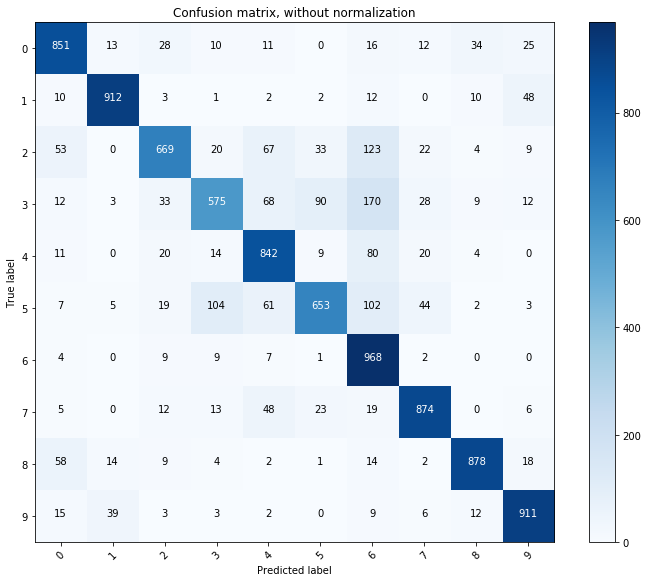

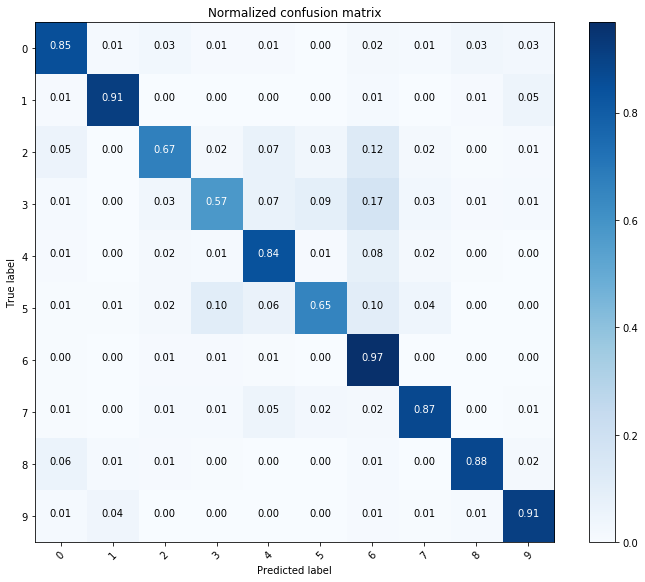

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [0]:
from sklearn.metrics import classification_report
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
report = classification_report(y_true=targets, y_pred=predictions, labels=classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.83      0.85      0.84      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.83      0.67      0.74      1000
         cat       0.76      0.57      0.66      1000
        deer       0.76      0.84      0.80      1000
         dog       0.80      0.65      0.72      1000
        frog       0.64      0.97      0.77      1000
       horse       0.87      0.87      0.87      1000
        ship       0.92      0.88      0.90      1000
       truck       0.88      0.91      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



loss	index	true		predicted	probability
2.2712	2405	cat		frog		1.0000
1.9942	779	dog		frog		0.9999
1.5151	2226	bird		frog		0.9994
1.4992	7311	automobile		truck		0.9982
1.3717	3501	truck		automobile		0.9989
1.3555	3618	deer		bird		0.9954
1.3332	8757	ship		frog		0.9620
1.3307	4036	horse		airplane		0.9902
1.3241	2532	airplane		automobile		0.9977
1.3026	1673	bird		frog		0.9983


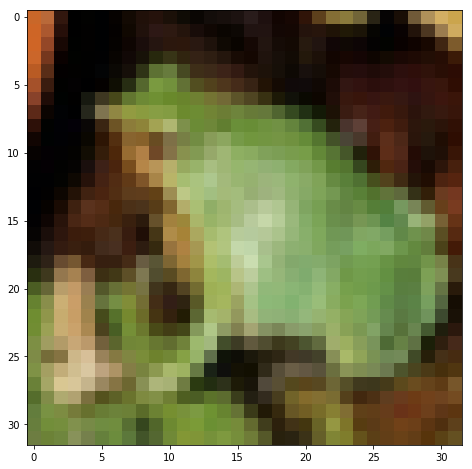

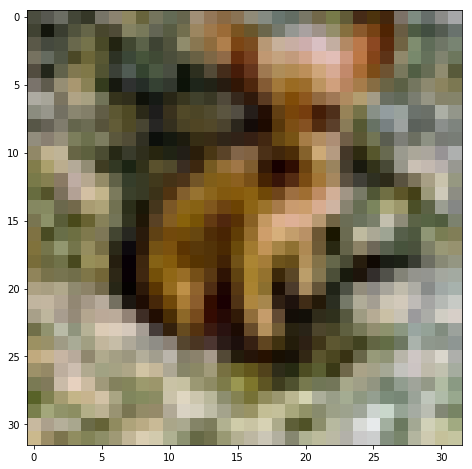

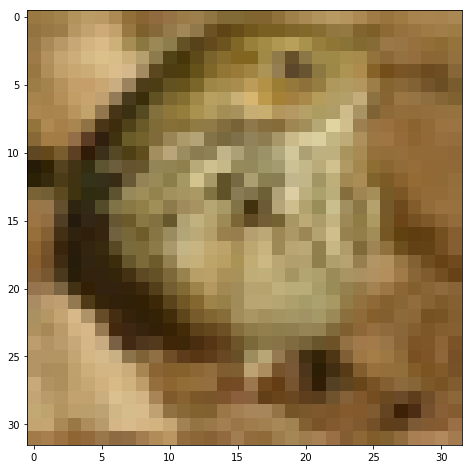

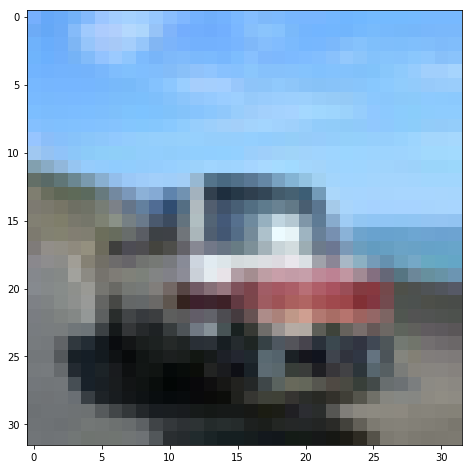

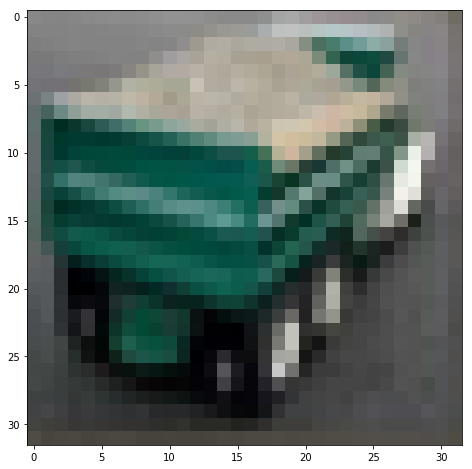

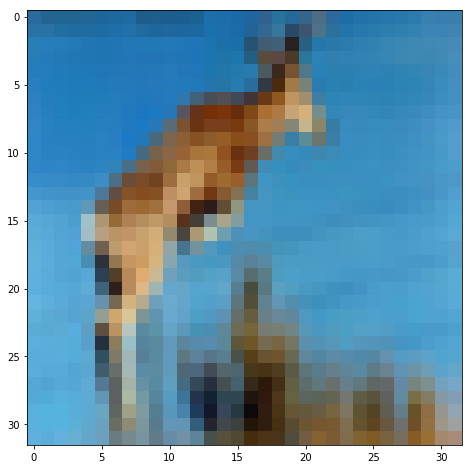

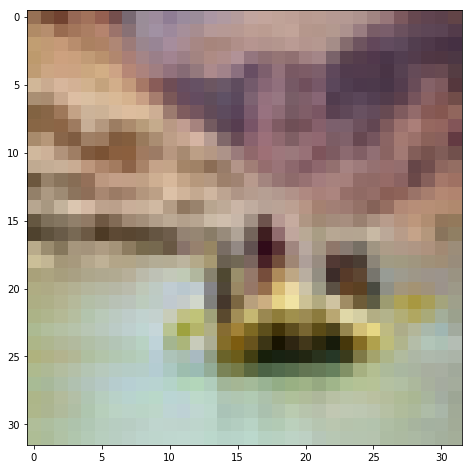

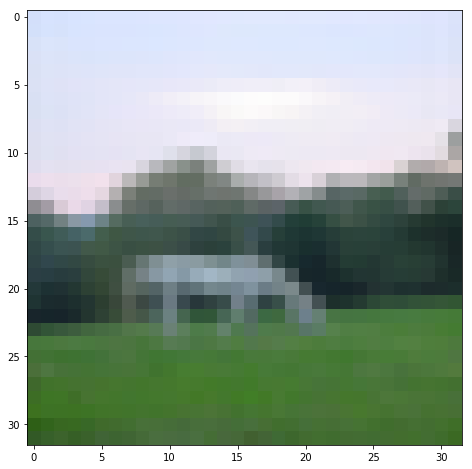

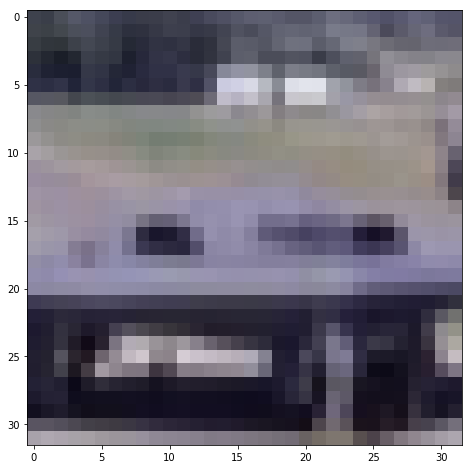

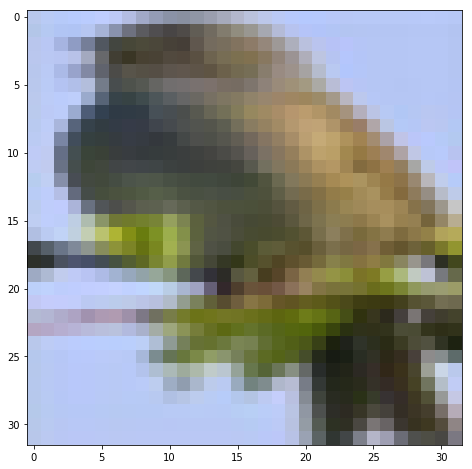

In [0]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\t\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), [class_names[t] for t in targets], [class_names[p] for p in predictions], max_probs)), reverse=True)[:10]
for error in top_errors:
    print('%.04f\t%d\t%s\t\t%s\t\t%.04f'%error)
    plt.figure()
    if gray:
        plt.imshow(x_test[error[1]][..., 0], cmap='gray')
    else:
        plt.imshow(x_test[error[1]])